In [1]:
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
from scipy.io import arff
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline

In [3]:
import numpy as np
import pandas as pd
#import lightgbm as lgb
#from lightgbm import LGBMRegressor
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, PolynomialFeatures, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import os
import time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import sklearn.dummy 

In [4]:
# a dictionary to restore the result
trials_result = {}


In [5]:
data = arff.loadarff('data.arff')


In [5]:
type(data[0]) #numpy.ndarray
type(data[1]) #scipy.io.arff.arffread.MetaData

scipy.io.arff.arffread.MetaData

In [22]:
pd.DataFrame(data[0]).head()

,CO2 0,CO2 1,CO2 2,CO2 3,CO2 4,CO2 5,CO2 6,CO2 7,CO2 8,CO2 9,...,m374.0818 1,m374.0818 2,m374.0818 3,m374.0818 4,m374.0818 5,m374.0818 6,m374.0818 7,m374.0818 8,m374.0818 9,target
0,750.271,750.094,750.380,750.726,750.890,750.860,749.192,748.599,749.077,749.605,...,0.132028,0.171277,0.167796,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,b'0'
1,750.094,750.380,750.726,750.890,750.860,749.192,748.599,749.077,749.605,749.638,...,0.171277,0.167796,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049,b'0'
2,750.380,750.726,750.890,750.860,749.192,748.599,749.077,749.605,749.638,750.009,...,0.167796,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049,0.173276,b'0'
3,750.726,750.890,750.860,749.192,748.599,749.077,749.605,749.638,750.009,752.381,...,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049,0.173276,0.133951,b'0'
4,750.890,750.860,749.192,748.599,749.077,749.605,749.638,750.009,752.381,754.066,...,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049,0.173276,0.133951,0.180807,b'1'


In [6]:
df = pd.DataFrame(data[0])
#df.to_csv('original_data.csv')
df = pd.get_dummies(df, columns = ['target'])

In [157]:
df.head()
df.shape

(1085, 3120)

In [159]:
 df.iloc[:,-1].values

array([0, 0, 0, ..., 1, 1, 1], dtype=uint8)

## tree selection important variables

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier

X = df.iloc[:,:-2]
y = df.iloc[:,-1]
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.feature_selection import SelectFromModel
imp = SimpleImputer(missing_values = np.nan, strategy = "mean",verbose=0)
imp = imp.fit(X)
X = imp.transform(X)

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape       

(1085, 1036)

## tree seletion+gaussianNB

In [43]:
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier

import random

X = df.iloc[:,:-2].values
y = df.iloc[:,-1].values
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.feature_selection import SelectFromModel
imp = SimpleImputer(missing_values = np.nan, strategy = "mean",verbose=0)
imp = imp.fit(X)
X = imp.transform(X)

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)

model = SelectFromModel(clf, prefit=True)
X_sel = model.transform(X)

result = []
 
for i in range(15):
    X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=.3, random_state=random.randint(0,10000))

    # imputation with mean                                                    
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', verbose=0)

    etc = ExtraTreesClassifier(n_estimators=50)
    # map to normal distribution 加上以后更低了0.6595092024539877
    #quantile_transformer =  preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
    # gassian分布： 0.6748466257668712
    # Normalization
    norm = preprocessing.Normalizer()
    pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
    # bins
    bins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    # Naive Bayes
    gnb = GaussianNB()
    # kbest
    selector = SelectKBest(mutual_info_classif,k=750)

    steps = [('slc',selector),
            ('clf', gnb)]

    pipe = Pipeline(steps = steps)

    pipe.fit(X_train, y_train)
    print('Test accuracy: %.3f' % pipe.score(X_test, y_test))
    result.append(pipe.score(X_test, y_test))

'''
from sklearn.model_selection import GridSearchCV
parameters = {}
#parameters['clean__strategy'] = ['mean', 'median', 'most_frequent']
#parameters['bins__strategy']=['uniform', 'quantile']
parameters['slc__k'] = [500,750,1000]
CV = GridSearchCV(estimator = pipe, param_grid = parameters, n_jobs= 2, cv = 3)

CV.fit(X_train, y_train)   

print('Best score and parameter combination = ')
print(CV.best_score_)    
print(CV.best_params_)    



from sklearn.metrics import accuracy_score
y_pred = CV.predict(X_test)
print(accuracy_score(y_test, y_pred))
'''

Test accuracy: 0.693
Test accuracy: 0.669
Test accuracy: 0.650
Test accuracy: 0.678
Test accuracy: 0.675
Test accuracy: 0.632
Test accuracy: 0.663
Test accuracy: 0.690
Test accuracy: 0.702
Test accuracy: 0.702
Test accuracy: 0.709
Test accuracy: 0.675
Test accuracy: 0.690
Test accuracy: 0.715
Test accuracy: 0.696


"\nfrom sklearn.model_selection import GridSearchCV\nparameters = {}\n#parameters['clean__strategy'] = ['mean', 'median', 'most_frequent']\n#parameters['bins__strategy']=['uniform', 'quantile']\nparameters['slc__k'] = [500,750,1000]\nCV = GridSearchCV(estimator = pipe, param_grid = parameters, n_jobs= 2, cv = 3)\n\nCV.fit(X_train, y_train)   \n\nprint('Best score and parameter combination = ')\nprint(CV.best_score_)    \nprint(CV.best_params_)    \n\n\n\nfrom sklearn.metrics import accuracy_score\ny_pred = CV.predict(X_test)\nprint(accuracy_score(y_test, y_pred))\n"

In [44]:
print(np.mean(result))
#all_result = []
all_result.append(result)

0.6826175869120654


In [42]:
#1 trees选过+norm+select 
#2 trees选过+norm+select+bins
#3 trees选过+select+bins
#4 trees选过+select+bins again
#5 trees选过+select 
np.mean(all_result[2])

0.6732106339468302

In [33]:
np.mean(all_result[0]);np.mean(all_result[1])
#np.var(all_result[1])

0.6550102249488753

In [28]:
len(model.get_support())
fit_attributes = df.iloc[:,:-2].columns[model.get_support()]

In [29]:
scores = selector.scores_
#len(scores)
data_score = {'attributes':fit_attributes,'score':scores}
data_score
df_score_attributes = pd.DataFrame(data_score)
five_best_attributes = df_score_attributes.sort_values(by='score',ascending=False).attributes[:5]

In [30]:
five_best_attributes

2    CO2 3
1    CO2 1
0    CO2 0
3    CO2 4
5    CO2 6
Name: attributes, dtype: object

### Random Forest select attributes

In [147]:
X = df.iloc[:,:-2].values
y = df.iloc[:,-1].values

In [130]:
#feature_importances_
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=random.randint(0,10000))

# imputation with mean                                                    
imp = SimpleImputer(missing_values=np.nan, strategy='mean', verbose=0)
# map to normal distribution 加上以后更低了0.6595092024539877
#quantile_transformer =  preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
# gassian分布： 0.6748466257668712
# Normalization
norm = preprocessing.Normalizer()
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
# bins
bins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
# Naive Bayes
rdf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
# kbest
selector = SelectKBest(mutual_info_classif,k=100)

steps = [('clean',imp),
         ('clf', rdf)]

pipe = Pipeline(steps = steps)

pipe.fit(X_train, y_train)
print('Test accuracy: %.3f' % pipe.score(X_test, y_test))

from sklearn.model_selection import GridSearchCV
parameters = {}
parameters['clf__n_estimators'] = [  1500,1800,2000,2500,3000]

CV = GridSearchCV(estimator = pipe, param_grid = parameters, n_jobs= 2, cv = 3)

CV.fit(X_train, y_train)   

print('Best score and parameter combination = ')
print(CV.best_score_)    
print(CV.best_params_)    





Test accuracy: 0.702
Best score and parameter combination = 
0.7602108036890646
{'clf__n_estimators': 1500}


### take out the attributes from rdf

In [57]:
type(rdf.feature_importances_)
rdf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)>

In [54]:
df.iloc[:,:-2]

,CO2 0,CO2 1,CO2 2,CO2 3,CO2 4,CO2 5,CO2 6,CO2 7,CO2 8,CO2 9,...,m374.0818 0,m374.0818 1,m374.0818 2,m374.0818 3,m374.0818 4,m374.0818 5,m374.0818 6,m374.0818 7,m374.0818 8,m374.0818 9
0,750.271,750.094,750.380,750.726,750.890,750.860,749.192,748.599,749.077,749.605,...,0.140104,0.132028,0.171277,0.167796,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541
1,750.094,750.380,750.726,750.890,750.860,749.192,748.599,749.077,749.605,749.638,...,0.132028,0.171277,0.167796,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049
2,750.380,750.726,750.890,750.860,749.192,748.599,749.077,749.605,749.638,750.009,...,0.171277,0.167796,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049,0.173276
3,750.726,750.890,750.860,749.192,748.599,749.077,749.605,749.638,750.009,752.381,...,0.167796,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049,0.173276,0.133951
4,750.890,750.860,749.192,748.599,749.077,749.605,749.638,750.009,752.381,754.066,...,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049,0.173276,0.133951,0.180807
5,750.860,749.192,748.599,749.077,749.605,749.638,750.009,752.381,754.066,756.478,...,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049,0.173276,0.133951,0.180807,0.113051
6,749.192,748.599,749.077,749.605,749.638,750.009,752.381,754.066,756.478,757.895,...,0.182266,0.167652,0.160940,0.130541,0.216049,0.173276,0.133951,0.180807,0.113051,0.175844
7,748.599,749.077,749.605,749.638,750.009,752.381,754.066,756.478,757.895,757.557,...,0.167652,0.160940,0.130541,0.216049,0.173276,0.133951,0.180807,0.113051,0.175844,0.115246
8,749.077,749.605,749.638,750.009,752.381,754.066,756.478,757.895,757.557,757.911,...,0.160940,0.130541,0.216049,0.173276,0.133951,0.180807,0.113051,0.175844,0.115246,0.163491
9,749.605,749.638,750.009,752.381,754.066,756.478,757.895,757.557,757.911,758.856,...,0.130541,0.216049,0.173276,0.133951,0.180807,0.113051,0.175844,0.115246,0.163491,0.174898


In [131]:
data_score = {'attributes':df.iloc[:,:-2].columns,'score':(rdf.feature_importances_)}
data_score
df_score_attributes = pd.DataFrame(data_score)
threeh_best_attributes = df_score_attributes.sort_values(by='score',ascending=False).attributes[:1500]

In [132]:
threeh_best_attributes = df_score_attributes.sort_values(by='score',ascending=False).attributes[:300]

In [133]:
X = df[pd.DataFrame(threeh_best_attributes).iloc[:,:1500].attributes]
y = df.iloc[:,-1].values

### random forest choose 300 and then fit

In [134]:
result = []
for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=random.randint(0,10000))

    # imputation with mean                                                    
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', verbose=0)
    # map to normal distribution 加上以后更低了0.6595092024539877
    #quantile_transformer =  preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
    # gassian分布： 0.6748466257668712
    # Normalization
    norm = preprocessing.Normalizer()
    pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
    # bins
    bins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    # Naive Bayes
    gnb = GaussianNB()
    dum = sklearn.dummy.DummyClassifier(strategy='most_frequent')
    # kbest
    selector = SelectKBest(mutual_info_classif,k=150)

    steps = [('clean',imp),
              ('norm',norm),
             ('slc',selector),
             ('clf', gnb)]

    pipe = Pipeline(steps = steps)

    pipe.fit(X_train, y_train)
    
    result.append(pipe.score(X_test, y_test))
print(np.mean(result),np.var(result))


0.6353783231083844 0.0003605287699532869


### 1/10 rdf+all

In [95]:
## X is already 1/10

In [101]:
#feature_importances_
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=random.randint(0,10000))

# imputation with mean                                                    
imp = SimpleImputer(missing_values=np.nan, strategy='mean', verbose=0)
# map to normal distribution 加上以后更低了0.6595092024539877
#quantile_transformer =  preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
# gassian分布： 0.6748466257668712
# Normalization
norm = preprocessing.Normalizer()
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
# bins
bins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
# Naive Bayes
rdf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
# kbest
selector = SelectKBest(mutual_info_classif,k=100)

steps = [('clean',imp),
         ('clf', rdf)]

pipe = Pipeline(steps = steps)

pipe.fit(X_train, y_train)
print('Test accuracy: %.3f' % pipe.score(X_test, y_test))

from sklearn.model_selection import GridSearchCV
parameters = {}
parameters['clf__n_estimators'] = [250,280, 300,310]

CV = GridSearchCV(estimator = pipe, param_grid = parameters, n_jobs= 2, cv = 3)

CV.fit(X_train, y_train)   

print('Best score and parameter combination = ')
print(CV.best_score_)    
print(CV.best_params_)    

Test accuracy: 0.736


D:\anaconda3\lib\site-packages\sklearn\externals\joblib\disk.py:122: UserWarning: Unable to delete folder C:\Users\lenovo\AppData\Local\Temp\joblib_memmapping_folder_12608_8348954945 after 5 tentatives.
  .format(folder_path, RM_SUBDIRS_N_RETRY))


PermissionError: [WinError 32] 另一个程序正在使用此文件，进程无法访问。: 'C:\\Users\\lenovo\\AppData\\Local\\Temp\\joblib_memmapping_folder_12608_8348954945\\12608-1464591148032-dc47452466f94a4bbfe232c84a275a70.pkl'

### random forest choose 100 out of 300

In [106]:
len(rdf.feature_importances_)

300

In [108]:
data_score = {'attributes':X_train.columns,'score':rdf.feature_importances_}
data_score
df_score_attributes = pd.DataFrame(data_score)
oneh_best_attributes = df_score_attributes.sort_values(by='score',ascending=False).attributes[:100]

In [110]:
oneh_best_attributes

52      m33.0335 8
8       m33.0335 5
26      m33.0335 1
6       m33.0335 0
37      m61.0284 0
4       m33.0335 7
7       m47.0491 0
43      m61.0284 3
5       m33.0335 4
36      m43.0178 2
3       m33.0335 2
19      m43.0178 4
0       m61.0284 1
38      m61.0284 7
11      m43.0178 7
69      m47.0491 3
14      m47.0491 2
46      m65.0603 4
49      m48.0542 5
47      m43.0178 1
30      m61.0284 5
90      m61.0284 4
32      m33.0335 9
2       m33.0335 6
1       m33.0335 3
12      m29.9974 0
23      m43.0542 1
22      m43.0178 9
9       m43.0178 8
25      m43.0178 0
          ...     
24      m43.0542 9
193    m153.1274 6
192          m39 9
48      m60.0526 0
161     m42.0092 2
106    m373.0832 1
162    m157.1669 4
55     m357.0682 0
197    m373.0832 7
104    m355.0726 0
98      m74.0688 2
101     m69.0699 4
216    m122.0219 7
167     m37.0227 9
97      m43.0542 0
115     m48.0542 6
16           CO2 6
112     m75.0440 9
99      m45.0335 7
59           CO2 1
151     m79.0542 0
210    m136.

In [111]:
X = df[pd.DataFrame(oneh_best_attributes).attributes]
y = df.iloc[:,-1].values

### And then fit gnb

In [117]:
result = []
for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=random.randint(0,10000))

    # imputation with mean                                                    
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', verbose=0)
    # map to normal distribution 加上以后更低了0.6595092024539877
    #quantile_transformer =  preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
    # gassian分布： 0.6748466257668712
    # Normalization
    norm = preprocessing.Normalizer()
    pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
    # bins
    bins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    # Naive Bayes
    gnb = GaussianNB()
    dum = sklearn.dummy.DummyClassifier(strategy='most_frequent')
    # kbest
    selector = SelectKBest(mutual_info_classif,k=50)

    steps = [('clean',imp),
              ('norm',norm),
             ('slc',selector),
             ('bins',bins),
             ('clf', gnb)]

    pipe = Pipeline(steps = steps)

    pipe.fit(X_train, y_train)
    
    result.append(pipe.score(X_test, y_test))
print(np.mean(result),np.var(result))


0.6556237218813906 0.0006460745814880334


In [34]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,3110,3111,3112,3113,3114,3115,3116,3117,3118,3119
0,750.271,750.094,750.380,750.726,750.890,750.860,749.192,748.599,749.077,749.605,...,0.140104,0.132028,0.171277,0.167796,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541
1,750.094,750.380,750.726,750.890,750.860,749.192,748.599,749.077,749.605,749.638,...,0.132028,0.171277,0.167796,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049
2,750.380,750.726,750.890,750.860,749.192,748.599,749.077,749.605,749.638,750.009,...,0.171277,0.167796,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049,0.173276
3,750.726,750.890,750.860,749.192,748.599,749.077,749.605,749.638,750.009,752.381,...,0.167796,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049,0.173276,0.133951
4,750.890,750.860,749.192,748.599,749.077,749.605,749.638,750.009,752.381,754.066,...,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049,0.173276,0.133951,0.180807


### original 

In [34]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,3110,3111,3112,3113,3114,3115,3116,3117,3118,3119
0,750.271,750.094,750.380,750.726,750.890,750.860,749.192,748.599,749.077,749.605,...,0.140104,0.132028,0.171277,0.167796,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541
1,750.094,750.380,750.726,750.890,750.860,749.192,748.599,749.077,749.605,749.638,...,0.132028,0.171277,0.167796,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049
2,750.380,750.726,750.890,750.860,749.192,748.599,749.077,749.605,749.638,750.009,...,0.171277,0.167796,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049,0.173276
3,750.726,750.890,750.860,749.192,748.599,749.077,749.605,749.638,750.009,752.381,...,0.167796,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049,0.173276,0.133951
4,750.890,750.860,749.192,748.599,749.077,749.605,749.638,750.009,752.381,754.066,...,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049,0.173276,0.133951,0.180807


In [77]:
pd.DataFrame(threeh_best_attributes).iloc[:,:300].attributes

751      m61.0284 1
183      m33.0335 3
186      m33.0335 6
182      m33.0335 2
187      m33.0335 7
184      m33.0335 4
180      m33.0335 0
480      m47.0491 0
185      m33.0335 5
368      m43.0178 8
489      m47.0491 9
367      m43.0178 7
130      m29.9974 0
752      m61.0284 2
482      m47.0491 2
745      m60.0526 5
6             CO2 6
700      m59.0491 0
3016    m235.2072 6
364      m43.0178 4
363      m43.0178 3
2             CO2 2
369      m43.0178 9
371      m43.0542 1
379      m43.0542 9
360      m43.0178 0
181      m33.0335 1
742      m60.0526 2
2783    m153.1274 3
215      m34.0372 5
           ...     
2032    m115.0754 2
2123    m120.9000 3
2304    m125.1393 4
2305    m125.1393 5
2306    m125.1393 6
2033    m115.0754 3
2307    m125.1393 7
2035    m115.0754 5
2036    m115.0754 6
2308    m125.1393 8
2309    m125.1393 9
2122    m120.9000 2
2121    m120.9000 1
2120    m120.9000 0
2119    m120.1048 9
2336    m126.9563 6
2310    m125.9574 0
2311    m125.9574 1
2118    m120.1048 8


In [92]:
num_list= []
for i in range(df.shape[1]):
    if i%10 == 0:
        num_list.append(i)
df_drop_attributes_one_ten = df.loc[:, df.columns[num_list]]

In [93]:
df_drop_attributes_one_ten["target"] = df["target_b'1'"]
df_drop_attributes_one_ten.head()

,CO2 0,m14.0028 0,m15.0238 0,m15.9962 0,m16.0201 0,m17.0260 0,m18.0338 0,m19.0088 0,m20.0236 0,m21 0,...,m355.0682 0,m355.0726 0,m356.0714 0,m357.0682 0,m371.0984 0,m372.0993 0,m373.0832 0,m374.0818 0,target_b'0',target
0,750.271,1.96568,3.29687,1.99962,1.109110,366.062,4321.94,12189.7,435.984,21932.3,...,NaN,0.832256,0.328058,0.294169,0.425897,0.210335,0.299392,0.140104,1,0
1,750.094,1.86616,4.01177,2.05227,0.708407,367.915,4315.24,12044.3,440.814,21907.2,...,NaN,0.837405,0.279425,0.329846,0.410070,0.231868,0.228481,0.132028,1,0
2,750.380,1.46125,3.56826,1.88890,0.993779,365.152,4352.70,12251.3,441.006,21760.0,...,NaN,0.719436,0.303829,0.217724,0.391563,0.281241,0.291495,0.171277,1,0
3,750.726,2.04741,3.34417,1.87937,1.011980,366.044,4307.40,12082.5,438.682,21901.2,...,NaN,0.804803,0.290422,0.241821,0.440084,0.262609,0.315239,0.167796,1,0
4,750.890,1.86874,3.33423,2.00630,1.203720,364.757,4328.59,12160.7,439.237,21968.4,...,NaN,0.735205,0.329777,0.254894,0.434809,0.204408,0.245891,0.141710,0,1


In [40]:
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB

X = df.iloc[:,:-2].values
y = df.iloc[:,-1].values
import random


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=random.randint(0,10000))

# imputation with mean                                                    
imp = SimpleImputer(missing_values=np.nan, strategy='mean', verbose=0)
# map to normal distribution 加上以后更低了0.6595092024539877
#quantile_transformer =  preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
# gassian分布： 0.6748466257668712
# Normalization
norm = preprocessing.Normalizer()
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
# bins
bins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
# Naive Bayes
gnb = GaussianNB()
# kbest
selector = SelectKBest(mutual_info_classif,k=100)

steps = [('clean',imp),
        ('norm',norm),
        ('slc',selector),
        ('clf', gnb)]

pipe = Pipeline(steps = steps)

pipe.fit(X_train, y_train)
print('Test accuracy: %.3f' % pipe.score(X_test, y_test))


from sklearn.model_selection import GridSearchCV
parameters = {}
parameters['clean__strategy'] = ['mean', 'median', 'most_frequent']
#parameters['bins__strategy']=['uniform', 'quantile']
parameters['slc__k'] = [110,125,130,150]
CV = GridSearchCV(estimator = pipe, param_grid = parameters, n_jobs= 2, cv = 3)

CV.fit(X_train, y_train)   

print('Best score and parameter combination = ')
print(CV.best_score_)    
print(CV.best_params_)    



from sklearn.metrics import accuracy_score
y_pred = CV.predict(X_test)
print(accuracy_score(y_test, y_pred))

In [41]:
import random


In [121]:
result = []
for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

    # imputation with mean                                                    
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', verbose=0)
    # map to normal distribution 加上以后更低了0.6595092024539877
    #quantile_transformer =  preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
    # gassian分布： 0.6748466257668712
    # Normalization
    norm = preprocessing.Normalizer()
    pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
    # bins
    bins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    # Naive Bayes
    gnb = GaussianNB()
    dum = sklearn.dummy.DummyClassifier(strategy='most_frequent')
    # kbest
    selector = SelectKBest(mutual_info_classif,k=100)

    steps = [('clean',imp),
              ('norm',norm),
             ('slc',selector),
             ('clf', gnb)]

    pipe = Pipeline(steps = steps)

    pipe.fit(X_train, y_train)
    
    result.append(pipe.score(X_test, y_test))
print(np.mean(result),np.var(result))


0.6963190184049078 1.232595164407831e-32


In [118]:
trials_result['majority'] = [0.6530368098159509,0.0004102327900937185]
trials_result['clean_gnb'] = [0.6571472392638039, 0.0008440014678760961]
trials_result['clean_slcr_bgn'] = [0.6696319018404908,0.0006888667243780343]
trials_result['1/10_cl_slc_bgn'] = [0.6612474437627811,0.00041758147548730544]
trials_result['5/10_cl_slc_bgn']=[0.6605316973415133, 0.0004129708390312859]
trials_result['1/10_cl_slc_bin_bgn'] = [0.6181, 0.00004]
trials_result['1/10_cl_slc_bin_bgn'] = [0.6273006134969326,0.00043393302972135467]
trials_result['rdf_cl_slc_bin_bgn'] = [0.642126789366053, 0.0004782097766402778]
trials_result['1/10_rdf_slc_bgn'] = [0.6441717791411042,0.0006003236854981368]
trials_result['1/10_tdf_slc_bin_bgn'] = [0.6556237218813906,0.0006460745814880334]

In [ ]:
('clean',imp),
            ('norm',norm),
            ('slc',selector),
             ('bins',bins),

In [20]:
np.var(result)
#result

0.0004496546727389062

In [ ]:
0.6782208588957055; 0.0006971470510745603 #加bins
0.6686503067484663; 0.0003820203997139524

In [ ]:
0.6696319018404908; 0.0003689450111031657

In [62]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=random.randint(0,10000))

# imputation with mean                                                    
imp = SimpleImputer(missing_values=np.nan, strategy='mean', verbose=0)
# map to normal distribution 加上以后更低了0.6595092024539877
#quantile_transformer =  preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
# gassian分布： 0.6748466257668712
# Normalization
norm = preprocessing.Normalizer()
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
# bins
bins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
# Naive Bayes
gnb = GaussianNB()
# kbest
selector = SelectKBest(mutual_info_classif,k=100)

steps = [('clean',imp),
        ('norm',norm),
        ('slc',selector),
        ('clf', gnb)]

pipe = Pipeline(steps = steps)

pipe.fit(X_train, y_train)
print('Test accuracy: %.3f' % pipe.score(X_test, y_test))


from sklearn.model_selection import GridSearchCV
parameters = {}
parameters['clean__strategy'] = ['mean', 'median', 'most_frequent']
#parameters['bins__strategy']=['uniform', 'quantile']
parameters['slc__k'] = [110,125,130,150]
CV = GridSearchCV(estimator = pipe, param_grid = parameters, n_jobs= 2, cv = 3)

CV.fit(X_train, y_train)   

print('Best score and parameter combination = ')
print(CV.best_score_)    
print(CV.best_params_)    



from sklearn.metrics import accuracy_score
y_pred = CV.predict(X_test)
print(accuracy_score(y_test, y_pred))

Test accuracy: 0.675
Best score and parameter combination = 
0.6666666666666666
{'clean__strategy': 'mean', 'slc__k': 150}
0.6748466257668712


Test accuracy: 0.715
Best score and parameter combination = 
0.6587615283267457
{'slc__k': 1250}
0.7177914110429447

## feature selection

In [87]:
scores = selector.scores_
#len(scores)
data_score = {'attributes':X_train.columns,'score':scores}
data_score
df_score_attributes = pd.DataFrame(data_score)
five_best_attributes = df_score_attributes.sort_values(by='score',ascending=False).attributes[:5]

In [88]:
five_best_scores = df_score_attributes.sort_values(by='score',ascending=False).score[:5]

In [90]:
five_best_attributes

130    CO2 0
59     CO2 1
21     CO2 2
102    CO2 3
16     CO2 6
Name: attributes, dtype: object

In [ ]:
pipe.named_steps["slc"].transform(X_train)

### Sklearn must take in numeric attributes!

In [ ]:
type(df)
df.shape # Attention: shape function there is no ()

### 1. Ignore: remove the NA lines

In [ ]:
print("Nrows before", df.shape[0])
df_removed = df.dropna()
print("Nrows after", df_removed.shape[0]) # we can't use remove the data, just remove every line with at least one missing value.

### 2. Imputation: replace the NA lines with global value

In [12]:
#impport numpy as np

# replace all NAN with -100000
df_replaced = df.fillna(-100000)
df_replaced.head()
df_replaced.to_csv('fill-10000.csv')

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
print(trials_result)

## Attention: sckilearn need all things to be numeric, no strings allowed

### 3.Imputation: replace with the mean/median

In [ ]:
sum(pd.isnull(df['m374.0818 8']))
np.mean(df['m374.0818 8'])

In [135]:
from sklearn.impute import SimpleImputer
import numpy as np
imp = SimpleImputer(missing_values = np.nan, strategy = "mean",verbose=0)
imp = imp.fit(X)
df_simpleimpute_mean = imp.transform(X)

In [149]:
imp = SimpleImputer(missing_values = np.nan, strategy = "mean",verbose=0)
imp = imp.fit(X)
df_simpleimpute_mean = imp.transform(X)

In [ ]:
type(df_simpleimpute_mean)
#print(df_simpleimpute_mean)
df_simpleimpute_mean.shape

In [ ]:
np.mean([0,float('nan'),1,2])

In [ ]:
np.mean(df_simpleimpute_mean[:,0])
np.mean(df.iloc(0))

In [ ]:
# df2.df = imp.transform(df2).toarray()

In [ ]:
df['m374.0818 8'].dtype

In [126]:
# axis=0, along the y axis, x is a vector!
df_imputemean = df.apply(lambda x: x.fillna(x.mean()),axis = 0)
# df_imputemean.head(1085)

In [ ]:
sum(pd.isnull(df_imputemedian['m374.0818 8']))


In [ ]:
df_imputemedian = df.apply(lambda x: x.fillna(x.median()),axis = 0)

### 4. Smooth by bins after the imputation

In [ ]:
np.array(df_imputemean.iloc[:,:-1].values)

In [ ]:
from sklearn import preprocessing


In [ ]:
bins=KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
bins.fit((df_imputemean.iloc[:,:-1].values))


In [143]:
sum(pd.isnull(df_imputemean['CO2 3']))

0

In [144]:
type(X)

numpy.ndarray

In [145]:
bins2=KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
bins2.fit((df_imputemean.iloc[:,:-2].values))
df_mean_bins = bins2.transform(df_imputemean.iloc[:,:-2].values)

In [131]:
df_imputemean.head()

,CO2 0,CO2 1,CO2 2,CO2 3,CO2 4,CO2 5,CO2 6,CO2 7,CO2 8,CO2 9,...,m374.0818 2,m374.0818 3,m374.0818 4,m374.0818 5,m374.0818 6,m374.0818 7,m374.0818 8,m374.0818 9,target_b'0',target_b'1'
0,750.271,750.094,750.380,750.726,750.890,750.860,749.192,748.599,749.077,749.605,...,0.171277,0.167796,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,1,0
1,750.094,750.380,750.726,750.890,750.860,749.192,748.599,749.077,749.605,749.638,...,0.167796,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049,1,0
2,750.380,750.726,750.890,750.860,749.192,748.599,749.077,749.605,749.638,750.009,...,0.141710,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049,0.173276,1,0
3,750.726,750.890,750.860,749.192,748.599,749.077,749.605,749.638,750.009,752.381,...,0.154595,0.182266,0.167652,0.160940,0.130541,0.216049,0.173276,0.133951,1,0
4,750.890,750.860,749.192,748.599,749.077,749.605,749.638,750.009,752.381,754.066,...,0.182266,0.167652,0.160940,0.130541,0.216049,0.173276,0.133951,0.180807,0,1


In [ ]:
matrix_mean_bin = bins2.transform(df_imputemean.iloc[:,:-1].values)

In [ ]:
df_mean_bin = pd.DataFrame(matrix_mean_bin)

In [ ]:
# Q: smooth each attribute?
from sklearn.preprocessing import KBinsDiscretizer

est = KBinsDiscretizer(n_bins = 3, encode = "ordinal", strategy = "quantile")

df_imputemean_bin = df_imputemean.copy()
split = pd.DataFrame(columns = df_imputemean.columns)
for i in df_imputemean.columns:
    split[i] = [[x] for x in df_imputemean[i]]
    est.fit(split[i])
    transformed = est.transform(split[i])
    df_imputemean_bin[i] =  transformed

In [ ]:
df_imputemean_bin = df_imputemean.copy()
for i in range(len(df_imputemean.columns.values)-2):
    x = df_imputemean.values[:,i]
    x = [[i] for i in x]
    est = preprocessing.KBinsDiscretizer(n_bins= 5, encode='ordinal').fit(x)
    df_imputemean_bin[df.columns[i]] = est.transform(x)    

In [ ]:
df_imputemean.values

df_imputemean_bin = df_imputemean.copy()
df_imputemean_bin[0] = est.transform(x)

In [ ]:

df_imputemean_bin = df_imputemean.copy()
x = df_imputemean.values[:,3119]
x = [[i] for i in x]
est = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal').fit(x)
est.transform(x)
    #df_imputemean_bin['CO2 0'] = est.transform(x)

    #df_imputemean.columns
    #df.columns[0]
    #df_imputemean_bin[df_imputemean.columns[0]] 
df_imputemean_bin[df.columns[3119]] = est.transform(x)

In [ ]:

df_imputemean_bin = df_imputemean.copy()
x = df_imputemean.values
x = [[i] for i in x]
est = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal').fit(x)
est.transform(x)
    #df_imputemean_bin['CO2 0'] = est.transform(x)

    #df_imputemean.columns
    #df.columns[0]
    #df_imputemean_bin[df_imputemean.columns[0]] 
df_imputemean_bin[df.columns[3119]] = est.transform(x)

In [ ]:
df_imputemean_bin

In [ ]:

est = preprocessing.KBinsDiscretizer(n_bins=[5 for i in range(len(df.columns))],  encode='ordinal').fit(X_train.values)

### 5. Remove outliers

In [ ]:
# Compute the interquartile range
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR =Q3-Q1

# Rmove outliers using the interquartile range method
df_outliersrm = X_train[~((X_train < (Q1 - 1.5*IQR))|(X_train > (Q3 + 1.5*IQR))).any(axis = 1)] #row? colomun?

print("Nrows before removing outliers", X_train.shape[0])
print("Nrows after removing outliers", df_outliersrm.shape[0])
# ther

In [ ]:
import numpy as np
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy = "most_frequent").fit(X_train, y_train)
predicted = clf.predict(X_test)
print(np.mean(predicted==y_test))

## Naive Bayes Classifier

In [ ]:
# accuracy 扰动
# 轻微的扰动，带来了很大的变动，随机性很强！

In [ ]:
# Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

predicted = gnb.predict(X_test)
print(np.mean(predicted == y_test))

In [ ]:
# Decision Tree
from sklearn import tree
from sklearn.model_selection import cross_val_score
clf = tree.DecisionTreeClassifier()

accuracies = cross_val_score(clf, X_train, y_train, scoring = "accuracy", cv=10)
print(np.mean(accuracies))

In [ ]:
# the entry of the Naive Bayes
df_newest = df_mean_bin

# split into 30% test set
proportion = 0.3
X = df_newest.iloc[:,:-2]
y = df_newest.iloc[0:,-1]
#X.head()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=proportion, random_state = 0)
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# Naive Bayes
gnb = GaussianNB()
#gnb.fit(X_train, y_train)


accuracies = cross_val_score(gnb, X_train, y_train, scoring = "accuracy", cv=10)


accuracies2 = cross_val_score(gnb, X_test, y_test, scoring = "accuracy", cv=10)
print("Accuracies from 10-fold cross-validation:",accuracies)
print("Mean accuracy:", np.mean(accuracies))
print(np.mean(accuracies))
# input contains NaN, infinity or a value too large for dtype('float64')
# impute missing value with a large number is not okay.

In [ ]:
trials_result['replaced'] = accuracies

In [ ]:
trials_result['df_imputemean'] = accuracies

In [ ]:
trials_result['df_imputemedian'] = accuracies

In [ ]:
trials_result['df_imputemean'].mean()-trials_result['df_imputemedian'] 

In [ ]:
trials_result['df_best_301'] = accuracies

## Feature Selection

In [147]:
df_mean_bins

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 0., 2., ..., 1., 1., 1.],
       [0., 2., 2., ..., 1., 1., 1.]])

In [155]:
df_imputemean.iloc[:,-1]


0       0
1       0
2       0
3       0
4       1
5       1
6       0
7       0
8       0
9       0
10      1
11      1
12      1
13      1
14      1
15      1
16      1
17      1
18      0
19      0
20      1
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
1055    0
1056    0
1057    1
1058    1
1059    1
1060    1
1061    1
1062    1
1063    1
1064    1
1065    1
1066    1
1067    1
1068    1
1069    1
1070    1
1071    1
1072    1
1073    1
1074    1
1075    1
1076    1
1077    1
1078    1
1079    1
1080    1
1081    1
1082    1
1083    1
1084    1
Name: target_b'1', Length: 1085, dtype: uint8

In [156]:

df_newest = df_mean_bins

# See tutorials at https://scikit-learn.org/stable/modules/feature_selection.html


# Convert class from string into integers
# enc = LabelEncoder()
# class_num = enc.fit_transform(df_newest["target_b'1'"])
class_num = df_imputemean.iloc[:,-1]

# Select the k=2 best numeric features, by measuring their mutual information with the class. 
# This code only applies to numeric attributes
numeric_attributes = df_imputemean.columns[:-2]
X_allNumericAttr = df_imputemean[numeric_attributes]
selector = SelectKBest(mutual_info_classif, k=5)
selector.fit(X_allNumericAttr, class_num)

# The columns to keep
kBestAttributes = selector.get_support(indices=True)
print("The best numeric attributes are", [ numeric_attributes[i] for i in kBestAttributes ])
# best_300 = [ numeric_attributes[i] for i in kBestAttributes ]

The best numeric attributes are ['CO2 0', 'CO2 5', 'CO2 6', 'CO2 8', 'CO2 9']


In [ ]:
df[best_300]

In [ ]:
['2','2','3']+['2']

In [ ]:
best_301 = best_300+["target_b'1'"]
best_301

In [ ]:
df.head(2)

In [ ]:
BFE

### 6. drop the columns that has all missing

In [71]:
df_drop_attributes = df.loc[:, df.isnull().mean() < 0.6]

In [31]:
df_drop_attributes.shape

(1085, 2925)

In [72]:
df_drop_attributes.shape

(1085, 3042)

In [50]:
sum(df.isnull().mean()>0.6)

80

In [80]:
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB

X = df_drop_attributes.iloc[:,:-2].values
y = df_drop_attributes.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)
                                                    
imp = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)
bins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
# Naive Bayes
gnb = GaussianNB()
# kbest
selector = SelectKBest(mutual_info_classif,k=1000)

steps = [('clean',imp),
         ('bins',bins),
        ('slc',selector),
        ('clf', gnb)]

pipe = Pipeline(steps = steps)

pipe.fit(X_train, y_train)
print('Test accuracy: %.3f' % pipe.score(X_test, y_test))

from sklearn.model_selection import GridSearchCV
parameters = {}
#parameters['clean__strategy'] = ['mean', 'median', 'most_frequent']
#parameters['bins__strategy']=['uniform', 'quantile']
parameters['slc__k'] = [1000,1250,1500,1750,2000]
CV = GridSearchCV(estimator = pipe, param_grid = parameters, n_jobs= 2, cv = 3)

CV.fit(X_train, y_train)   

print('Best score and parameter combination = ')

print(CV.best_score_)    
print(CV.best_params_)   

from sklearn.metrics import accuracy_score
y_pred = CV.predict(X_test)
print(accuracy_score(y_test, y_pred))

Test accuracy: 0.721
Best score and parameter combination = 
0.6455862977602108
{'slc__k': 1500}
0.7116564417177914


### 7. fill in the missing data by the value in a row forward

In [46]:
df_fill_by_row = df.fillna(axis=1,method='ffill')

In [90]:
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB

X = df_fill_by_row.iloc[:,:-2].values
y = df_fill_by_row.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)
                                                    
imp = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)
bins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
# Naive Bayes
gnb = GaussianNB()
# kbest
selector = SelectKBest(mutual_info_classif,k=1000)

steps = [('bins',bins),
        ('slc',selector),
        ('clf', gnb)]

pipe = Pipeline(steps = steps)

pipe.fit(X_train, y_train)
print('Test accuracy: %.3f' % pipe.score(X_test, y_test))

from sklearn.model_selection import GridSearchCV
parameters = {}
#parameters['clean__strategy'] = ['mean', 'median', 'most_frequent']
#parameters['bins__strategy']=['uniform', 'quantile']
parameters['slc__k'] = [500,1000,1500,2000,2500,2800,3000]
CV = GridSearchCV(estimator = pipe, param_grid = parameters, n_jobs= 2, cv = 3)

CV.fit(X_train, y_train)   

print('Best score and parameter combination = ')

print(CV.best_score_)    
print(CV.best_params_)   



from sklearn.metrics import accuracy_score
y_pred = CV.predict(X_test)
print(accuracy_score(y_test, y_pred))

Test accuracy: 0.635
Best score and parameter combination = 
0.6495388669301713
{'slc__k': 2500}
0.7177914110429447


### 8. 每隔十列保留一列

In [60]:
num_list= []
for i in range(df.shape[1]):
    if i%10 == 0:
        num_list.append(i)
df_drop_attributes_one_ten = df.loc[:, df.columns[num_list]]

In [83]:
df_drop_attributes_one_ten = df.loc[:, df.columns[num_list]]

In [162]:
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB

X = df_drop_attributes_one_ten.iloc[:,:-2].values
y = df_drop_attributes_one_ten.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)
                                                    
imp = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)
bins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
# Naive Bayes
gnb = GaussianNB()
# kbest
selector = SelectKBest(mutual_info_classif,k=300)

steps = [('clean',imp),
         ('bins',bins),
        ('slc',selector),
        ('clf', gnb)]

pipe = Pipeline(steps = steps)

pipe.fit(X_train, y_train)
print('Test accuracy: %.3f' % pipe.score(X_test, y_test))


from sklearn.model_selection import GridSearchCV
parameters = {}
#parameters['clean__strategy'] = ['mean', 'median', 'most_frequent']
#parameters['bins__strategy']=['uniform', 'quantile']
parameters['slc__k'] = [100,200,225,250,300]
CV = GridSearchCV(estimator = pipe, param_grid = parameters, n_jobs= 2, cv = 3)

CV.fit(X_train, y_train)   

print('Best score and parameter combination = ')

print(CV.best_score_)    
print(CV.best_params_)   


from sklearn.metrics import accuracy_score
y_pred = CV.predict(X_test)
print(accuracy_score(y_test, y_pred))

Test accuracy: 0.693
Best score and parameter combination = 
0.6455862977602108
{'slc__k': 100}
0.6748466257668712


In [87]:
from prettytable import PrettyTable

x = PrettyTable()

x.add_column("",["Preprocessing 1","Preprocessing 2","Preprocessing 3"])

x.add_column("Accuracy",[0.7177914110,0.7116564417,0.717791411])

x.add_column("Variance",[round()])


print(x)

+-----------------+--------------+
|                 |   Accuracy   |
+-----------------+--------------+
| Preprocessing 1 | 0.717791411  |
| Preprocessing 2 | 0.7116564417 |
| Preprocessing 3 | 0.717791411  |
+-----------------+--------------+


In [51]:
from prettytable import PrettyTable

x = PrettyTable()

x.add_column("five best attributes",["No.1","No.2","No.3","No.4","No.5"])

x.add_column("Attributes",five_best_attributes.tolist())

x.add_column("Scores",[round(i,4) for i in (five_best_scores).tolist()])


print(x)

+----------------------+------------+--------+
| five best attributes | Attributes | Scores |
+----------------------+------------+--------+
|         No.1         |   CO2 0    | 0.1732 |
|         No.2         | m59.0491 0 | 0.1542 |
|         No.3         | m18.0338 0 | 0.1341 |
|         No.4         | m29.9974 0 | 0.1141 |
|         No.5         | m41.0386 0 | 0.108  |
+----------------------+------------+--------+


In [172]:
[round(i,4) for i in (five_best_scores).tolist()]

[0.1074, 0.1071, 0.1058, 0.1027, 0.1023]

In [ ]:
trials_result['majority']

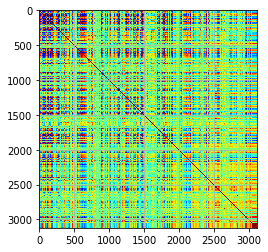

In [150]:
from matplotlib import pyplot as plt
from matplotlib import cm as cm
df = pd.DataFrame(df_simpleimpute_mean)
fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('jet', 30)
cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
ax1.grid(True)

# Add colorbar, make sure to specify tick locations to match desired ticklabels

plt.show()

In [148]:
X

array([[7.50271e+02, 7.50094e+02, 7.50380e+02, ..., 1.67652e-01,
        1.60940e-01, 1.30541e-01],
       [7.50094e+02, 7.50380e+02, 7.50726e+02, ..., 1.60940e-01,
        1.30541e-01, 2.16049e-01],
       [7.50380e+02, 7.50726e+02, 7.50890e+02, ..., 1.30541e-01,
        2.16049e-01, 1.73276e-01],
       ...,
       [7.71107e+02, 7.68527e+02, 7.64311e+02, ...,         nan,
                nan,         nan],
       [7.68527e+02, 7.64311e+02,         nan, ...,         nan,
                nan,         nan],
       [7.64311e+02,         nan,         nan, ...,         nan,
                nan,         nan]])